# Import Dependencies

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBRegressor

# Data Cleaning

Cleaning the Rookie of the Year dataset. The only columns that need to be kept are the Player Names, Points Won, Points Max, Share, and the year the rookie joined the NBA.

In [3]:
roys = pd.read_csv("roy_stats.csv")
roys

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Larry Bird,23,BOS,63.0,63.0,66,0.955,82,36.0,...,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980
1,2,Magic Johnson,20,LAL,3.0,3.0,66,0.045,77,36.3,...,7.7,7.3,2.4,0.5,0.530,0.226,0.810,10.5,0.180,1980
2,1,Darrell Griffith,22,UTA,19.0,19.0,69,0.275,81,35.4,...,3.6,2.4,1.3,0.5,0.464,0.192,0.716,0.4,0.006,1981
3,2,Kelvin Ransey,22,POR,18.0,18.0,69,0.261,80,30.4,...,2.4,6.9,1.1,0.1,0.452,0.097,0.749,2.8,0.056,1981
4,3,Larry Smith,23,GSW,14.0,14.0,69,0.203,82,31.4,...,12.1,1.1,0.9,0.8,0.512,NaN,0.588,6.1,0.113,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,2,Chet Holmgren,21,OKC,0.0,295.0,495,0.596,82,29.4,...,7.9,2.4,0.6,2.3,0.530,0.370,0.793,8.9,0.178,2024
255,3,Brandon Miller,21,CHO,0.0,86.0,495,0.174,74,32.2,...,4.3,2.4,0.9,0.6,0.440,0.373,0.827,0.8,0.015,2024
256,4,Jaime Jaquez Jr.,22,MIA,0.0,10.0,495,0.020,75,28.2,...,3.8,2.6,1.0,0.3,0.489,0.322,0.811,4.0,0.092,2024
257,5,Brandin Podziemski,20,GSW,0.0,4.0,495,0.008,74,26.6,...,5.8,3.7,0.8,0.2,0.454,0.385,0.633,4.1,0.100,2024


In [4]:
roys_cleaned = roys[["Player", "Pts Won", "Pts Max", "Share", "Year"]]
roys_cleaned

,Player,Pts Won,Pts Max,Share,Year
0,Larry Bird,63.0,66,0.955,1980
1,Magic Johnson,3.0,66,0.045,1980
2,Darrell Griffith,19.0,69,0.275,1981
3,Kelvin Ransey,18.0,69,0.261,1981
4,Larry Smith,14.0,69,0.203,1981
...,...,...,...,...,...
254,Chet Holmgren,295.0,495,0.596,2024
255,Brandon Miller,86.0,495,0.174,2024
256,Jaime Jaquez Jr.,10.0,495,0.020,2024
257,Brandin Podziemski,4.0,495,0.008,2024


Cleaning all rookie stats data. The main focus here was removing extra overheader rows that appear due to the nature of the html used for basketball-reference. Some names also had an asterisk next to their last name to denote that player receiving multiple awards. Since I'm only focused on the Rookie of the Year award and that classification models could have a difficult time parsing names with symbols, these will also be reformatted.

In [5]:
rookies = pd.read_csv("rookie_stats.csv")
rookies

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,1,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,3,Larry Bird*,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,4,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,5,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP,PTS,TRB,AST,STL,BLK,2025
3596,81,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,...,.386,.284,.658,18.5,6.9,2.3,1.4,0.5,0.2,2025
3597,82,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,...,.557,.414,.727,17.2,8.5,4.8,0.6,0.6,1.0,2025
3598,83,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,...,.444,.387,.841,26.2,11.7,3.2,1.7,0.6,0.1,2025


In [6]:
rookies = rookies[~rookies["G"].str.contains("Totals")]
rookies.head(25)

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,1,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,3,Larry Bird*,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,4,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,5,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
5,6,Bill Cartwright,"Oct 12, '79, NYK @ ATL",22,1,82,3150,665,1215,0,...,.547,NaN,.797,38.4,21.7,8.9,2.0,0.6,1.2,1980
6,7,Jeff Cook,"Oct 12, '79, PHO vs. GSW",23,1,66,904,129,275,0,...,.469,.000,.806,13.7,5.5,3.7,1.3,0.4,0.3,1980
7,8,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,...,.495,.000,.733,15.2,5.7,2.1,1.1,0.8,0.3,1980
8,9,John Coughran,"Oct 12, '79, GSW @ PHO",28,1,24,160,29,81,2,...,.358,.222,.571,6.7,2.8,0.8,0.5,0.3,0.0,1980
9,10,Terry Crosby,"Nov 13, '79, KCK vs. PHI",23,1,4,28,2,4,0,...,.500,NaN,1.000,7.0,1.5,0.3,1.8,0.0,0.0,1980


In [7]:
rookies = rookies[~rookies["Debut"].str.contains("Debut")]
rookies.head(25)

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,1,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,3,Larry Bird*,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,4,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,5,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
5,6,Bill Cartwright,"Oct 12, '79, NYK @ ATL",22,1,82,3150,665,1215,0,...,.547,NaN,.797,38.4,21.7,8.9,2.0,0.6,1.2,1980
6,7,Jeff Cook,"Oct 12, '79, PHO vs. GSW",23,1,66,904,129,275,0,...,.469,.000,.806,13.7,5.5,3.7,1.3,0.4,0.3,1980
7,8,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,...,.495,.000,.733,15.2,5.7,2.1,1.1,0.8,0.3,1980
8,9,John Coughran,"Oct 12, '79, GSW @ PHO",28,1,24,160,29,81,2,...,.358,.222,.571,6.7,2.8,0.8,0.5,0.3,0.0,1980
9,10,Terry Crosby,"Nov 13, '79, KCK vs. PHI",23,1,4,28,2,4,0,...,.500,NaN,1.000,7.0,1.5,0.3,1.8,0.0,0.0,1980


In [8]:
rookies.reset_index(drop=True, inplace = True)
rookies.head(25)

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,1,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,3,Larry Bird*,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,4,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,5,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
5,6,Bill Cartwright,"Oct 12, '79, NYK @ ATL",22,1,82,3150,665,1215,0,...,.547,NaN,.797,38.4,21.7,8.9,2.0,0.6,1.2,1980
6,7,Jeff Cook,"Oct 12, '79, PHO vs. GSW",23,1,66,904,129,275,0,...,.469,.000,.806,13.7,5.5,3.7,1.3,0.4,0.3,1980
7,8,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,...,.495,.000,.733,15.2,5.7,2.1,1.1,0.8,0.3,1980
8,9,John Coughran,"Oct 12, '79, GSW @ PHO",28,1,24,160,29,81,2,...,.358,.222,.571,6.7,2.8,0.8,0.5,0.3,0.0,1980
9,10,Terry Crosby,"Nov 13, '79, KCK vs. PHI",23,1,4,28,2,4,0,...,.500,NaN,1.000,7.0,1.5,0.3,1.8,0.0,0.0,1980


In [9]:
rookies["Player"] = rookies["Player"].str.replace("*", "", regex=False)
rookies

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,1,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,3,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,4,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,5,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445,80,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25,1,20,359,47,110,21,...,.427,.356,1.000,18.0,6.2,1.6,2.3,1.1,0.3,2025
3446,81,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,...,.386,.284,.658,18.5,6.9,2.3,1.4,0.5,0.2,2025
3447,82,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,...,.557,.414,.727,17.2,8.5,4.8,0.6,0.6,1.0,2025
3448,83,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,...,.444,.387,.841,26.2,11.7,3.2,1.7,0.6,0.1,2025


Next, I want to check for any duplicate entries. These will be deleted to keep the total stats for the entire season and assign the team based on where the player is after the trade deadline. 

In [10]:
duplicated = rookies[rookies.duplicated(subset=['Debut'])]
print ("Duplicated rows: ")
duplicated.head(50)

Duplicated rows: 


,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
7,8,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,...,.495,.000,.733,15.2,5.7,2.1,1.1,0.8,0.3,1980
12,13,Greg Deane,"Oct 12, '79, UTA @ POR",22,1,7,48,2,11,1,...,.182,1.000,.714,6.9,1.4,0.9,0.9,0.0,0.0,1980
13,14,Larry Demic,"Oct 12, '79, NYK @ ATL",22,1,82,1872,230,528,0,...,.436,NaN,.601,22.8,7.0,5.9,0.8,0.7,0.4,1980
19,20,Roy Hamilton,"Oct 12, '79, DET vs. IND",22,1,72,1116,115,287,0,...,.401,.000,.687,15.5,4.6,1.5,2.7,0.7,0.1,1980
20,21,Gerald Henderson,"Oct 12, '79, BOS vs. HOU",24,1,76,1061,191,382,2,...,.500,.333,.690,14.0,6.2,1.1,1.9,0.6,0.2,1980
21,22,Johnny High,"Oct 12, '79, PHO vs. GSW",22,1,82,1121,144,323,1,...,.446,.143,.674,13.7,5.0,2.1,1.5,0.9,0.2,1980
23,24,Phil Hubbard,"Oct 12, '79, DET vs. IND",23,1,64,1189,210,451,0,...,.466,.000,.750,18.6,9.1,5.0,1.1,0.8,0.2,1980
24,25,Geoff Huston,"Oct 12, '79, NYK @ ATL",22,1,71,923,94,241,3,...,.390,.176,.737,13.0,3.1,0.8,2.2,0.5,0.1,1980
30,31,Greg Kelser,"Oct 12, '79, DET vs. IND",22,1,50,1233,280,593,3,...,.472,.200,.719,24.7,14.2,5.5,2.2,1.2,0.7,1980
31,32,Irv Kiffin,"Oct 13, '79, SAS vs. DET",28,1,26,212,32,96,0,...,.333,NaN,.720,8.2,3.2,1.5,0.7,0.4,0.1,1980


In [11]:
rookies = rookies.drop_duplicates(subset=['Player'])
rookies.reset_index(drop=True, inplace = True)

In [13]:
rookies

,Rk,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,1,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,3,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,4,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,5,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,80,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25,1,20,359,47,110,21,...,.427,.356,1.000,18.0,6.2,1.6,2.3,1.1,0.3,2025
3424,81,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,...,.386,.284,.658,18.5,6.9,2.3,1.4,0.5,0.2,2025
3425,82,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,...,.557,.414,.727,17.2,8.5,4.8,0.6,0.6,1.0,2025
3426,83,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,...,.444,.387,.841,26.2,11.7,3.2,1.7,0.6,0.1,2025


Making a copy of the rookie dataframe for the cleaned rookie data and deleting the rank column. Then, I apply a lambda function on the Debut column in order to grab the team abbreviations and match them to the team that the rookie is playing for. The first team listed in the Debut column is the team that will be kept.

In [14]:
rookies_cleaned = rookies
del rookies_cleaned["Rk"]
rookies_cleaned.head(10)

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,FG%,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,.450,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,.493,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,.474,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,.462,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,.452,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980
5,Bill Cartwright,"Oct 12, '79, NYK @ ATL",22,1,82,3150,665,1215,0,0,...,.547,NaN,.797,38.4,21.7,8.9,2.0,0.6,1.2,1980
6,Jeff Cook,"Oct 12, '79, PHO vs. GSW",23,1,66,904,129,275,0,3,...,.469,.000,.806,13.7,5.5,3.7,1.3,0.4,0.3,1980
7,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,2,...,.495,.000,.733,15.2,5.7,2.1,1.1,0.8,0.3,1980
8,John Coughran,"Oct 12, '79, GSW @ PHO",28,1,24,160,29,81,2,9,...,.358,.222,.571,6.7,2.8,0.8,0.5,0.3,0.0,1980
9,Terry Crosby,"Nov 13, '79, KCK vs. PHI",23,1,4,28,2,4,0,0,...,.500,NaN,1.000,7.0,1.5,0.3,1.8,0.0,0.0,1980


In [15]:
rookies_cleaned["Teams_Played"] = rookies_cleaned["Debut"].apply(lambda x: x.split(',')[2])
rookies_cleaned

C:\Users\Elijah\AppData\Local\Temp\ipykernel_21420\2236043032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rookies_cleaned["Teams_Played"] = rookies_cleaned["Debut"].apply(lambda x: x.split(',')[2])


,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Teams_Played
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980,SEA @ SDC
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980,POR @ DET
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980,BOS vs. HOU
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980,WSB vs. IND
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980,IND @ DET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25,1,20,359,47,110,21,59,...,.356,1.000,18.0,6.2,1.6,2.3,1.1,0.3,2025,ATL @ OKC
3424,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,88,...,.284,.658,18.5,6.9,2.3,1.4,0.5,0.2,2025,TOR vs. LAL
3425,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,58,...,.414,.727,17.2,8.5,4.8,0.6,0.6,1.0,2025,MIA vs. ORL
3426,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,243,...,.387,.841,26.2,11.7,3.2,1.7,0.6,0.1,2025,MEM @ UTA


In [16]:
rookies_cleaned['Team'] = rookies_cleaned["Teams_Played"].str.split("vs. | @")
rookies_cleaned

C:\Users\Elijah\AppData\Local\Temp\ipykernel_21420\2629179555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rookies_cleaned['Team'] = rookies_cleaned["Teams_Played"].str.split("vs. | @")


,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Teams_Played,Team
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980,SEA @ SDC,"[ SEA, SDC]"
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980,POR @ DET,"[ POR, DET]"
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980,BOS vs. HOU,"[ BOS , HOU]"
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980,WSB vs. IND,"[ WSB , IND]"
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980,IND @ DET,"[ IND, DET]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25,1,20,359,47,110,21,59,...,1.000,18.0,6.2,1.6,2.3,1.1,0.3,2025,ATL @ OKC,"[ ATL, OKC]"
3424,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,88,...,.658,18.5,6.9,2.3,1.4,0.5,0.2,2025,TOR vs. LAL,"[ TOR , LAL]"
3425,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,58,...,.727,17.2,8.5,4.8,0.6,0.6,1.0,2025,MIA vs. ORL,"[ MIA , ORL]"
3426,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,243,...,.841,26.2,11.7,3.2,1.7,0.6,0.1,2025,MEM @ UTA,"[ MEM, UTA]"


In [17]:
index = rookies_cleaned.index
split_teams = pd.DataFrame(rookies_cleaned["Team"].tolist(), columns=["T1", "T2"], index=index)
split_teams


,T1,T2
0,SEA,SDC
1,POR,DET
2,BOS,HOU
3,WSB,IND
4,IND,DET
...,...,...
3423,ATL,OKC
3424,TOR,LAL
3425,MIA,ORL
3426,MEM,UTA


In [18]:
rookies_cleaned = pd.concat([rookies_cleaned, split_teams], axis=1)
rookies_cleaned

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Teams_Played,Team,T1,T2
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,4.7,2.9,0.4,0.3,0.8,1980,SEA @ SDC,"[ SEA, SDC]",SEA,SDC
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,11.3,1.8,1.9,0.9,0.1,1980,POR @ DET,"[ POR, DET]",POR,DET
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,21.3,10.4,4.5,1.7,0.6,1980,BOS vs. HOU,"[ BOS , HOU]",BOS,HOU
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,4.3,3.0,0.2,0.3,0.2,1980,WSB vs. IND,"[ WSB , IND]",WSB,IND
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,8.4,2.7,3.1,2.6,0.6,1980,IND @ DET,"[ IND, DET]",IND,DET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25,1,20,359,47,110,21,59,...,6.2,1.6,2.3,1.1,0.3,2025,ATL @ OKC,"[ ATL, OKC]",ATL,OKC
3424,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,88,...,6.9,2.3,1.4,0.5,0.2,2025,TOR vs. LAL,"[ TOR , LAL]",TOR,LAL
3425,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,58,...,8.5,4.8,0.6,0.6,1.0,2025,MIA vs. ORL,"[ MIA , ORL]",MIA,ORL
3426,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,243,...,11.7,3.2,1.7,0.6,0.1,2025,MEM @ UTA,"[ MEM, UTA]",MEM,UTA


In [19]:
del rookies_cleaned["Teams_Played"]
del rookies_cleaned["T2"]
del rookies_cleaned["Team"]

In [20]:
rookies_cleaned.rename(columns={'T1':'Tm'}, inplace=True)
rookies_cleaned

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,3P%,FT%,MP.1,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Tm
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,NaN,.673,10.8,4.7,2.9,0.4,0.3,0.8,1980,SEA
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,.421,.718,14.7,11.3,1.8,1.9,0.9,0.1,1980,POR
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,.406,.836,36.0,21.3,10.4,4.5,1.7,0.6,1980,BOS
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,NaN,.615,9.6,4.3,3.0,0.2,0.3,0.2,1980,WSB
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,.400,.782,24.7,8.4,2.7,3.1,2.6,0.6,1980,IND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25,1,20,359,47,110,21,59,...,.356,1.000,18.0,6.2,1.6,2.3,1.1,0.3,2025,ATL
3424,Ja'Kobe Walter,"Nov 1, '24, TOR vs. LAL",20,1,28,518,71,184,25,88,...,.284,.658,18.5,6.9,2.3,1.4,0.5,0.2,2025,TOR
3425,Kel'el Ware,"Oct 23, '24, MIA vs. ORL",20,1,31,533,107,192,24,58,...,.414,.727,17.2,8.5,4.8,0.6,0.6,1.0,2025,MIA
3426,Jaylen Wells,"Oct 23, '24, MEM @ UTA",21,1,48,1257,197,444,94,243,...,.387,.841,26.2,11.7,3.2,1.7,0.6,0.1,2025,MEM


Merging the ROTY and rookie stats data into one dataframe. There are null values as not every rookie receives ROTY shares, so the best practice would be to replace these null values with 0. This will cause numerical imbalance, but it is necessary for the model to be able to accept the data.

In [21]:
combined_stats = rookies_cleaned.merge(roys_cleaned, how="outer", on=["Player", "Year"])
combined_stats.head(15)

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Tm,Pts Won,Pts Max,Share
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,4.7,2.9,0.4,0.3,0.8,1980,SEA,NaN,NaN,NaN
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,11.3,1.8,1.9,0.9,0.1,1980,POR,NaN,NaN,NaN
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,21.3,10.4,4.5,1.7,0.6,1980,BOS,63.0,66.0,0.955
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,4.3,3.0,0.2,0.3,0.2,1980,WSB,NaN,NaN,NaN
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,8.4,2.7,3.1,2.6,0.6,1980,IND,NaN,NaN,NaN
5,Bill Cartwright,"Oct 12, '79, NYK @ ATL",22,1,82,3150,665,1215,0,0,...,21.7,8.9,2.0,0.6,1.2,1980,NYK,NaN,NaN,NaN
6,Jeff Cook,"Oct 12, '79, PHO vs. GSW",23,1,66,904,129,275,0,3,...,5.5,3.7,1.3,0.4,0.3,1980,PHO,NaN,NaN,NaN
7,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,2,...,5.7,2.1,1.1,0.8,0.3,1980,NYK,NaN,NaN,NaN
8,John Coughran,"Oct 12, '79, GSW @ PHO",28,1,24,160,29,81,2,9,...,2.8,0.8,0.5,0.3,0.0,1980,GSW,NaN,NaN,NaN
9,Terry Crosby,"Nov 13, '79, KCK vs. PHI",23,1,4,28,2,4,0,0,...,1.5,0.3,1.8,0.0,0.0,1980,KCK,NaN,NaN,NaN


In [22]:
combined_stats[["Pts Won", "Pts Max", "Share"]] = combined_stats[["Pts Won", "Pts Max", "Share"]].fillna(0)
combined_stats.head(10)

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Tm,Pts Won,Pts Max,Share
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,4.7,2.9,0.4,0.3,0.8,1980,SEA,0.0,0.0,0.000
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,11.3,1.8,1.9,0.9,0.1,1980,POR,0.0,0.0,0.000
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,21.3,10.4,4.5,1.7,0.6,1980,BOS,63.0,66.0,0.955
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,4.3,3.0,0.2,0.3,0.2,1980,WSB,0.0,0.0,0.000
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,8.4,2.7,3.1,2.6,0.6,1980,IND,0.0,0.0,0.000
5,Bill Cartwright,"Oct 12, '79, NYK @ ATL",22,1,82,3150,665,1215,0,0,...,21.7,8.9,2.0,0.6,1.2,1980,NYK,0.0,0.0,0.000
6,Jeff Cook,"Oct 12, '79, PHO vs. GSW",23,1,66,904,129,275,0,3,...,5.5,3.7,1.3,0.4,0.3,1980,PHO,0.0,0.0,0.000
7,Hollis Copeland,"Oct 12, '79, NYK @ ATL",24,1,75,1142,182,368,0,2,...,5.7,2.1,1.1,0.8,0.3,1980,NYK,0.0,0.0,0.000
8,John Coughran,"Oct 12, '79, GSW @ PHO",28,1,24,160,29,81,2,9,...,2.8,0.8,0.5,0.3,0.0,1980,GSW,0.0,0.0,0.000
9,Terry Crosby,"Nov 13, '79, KCK vs. PHI",23,1,4,28,2,4,0,0,...,1.5,0.3,1.8,0.0,0.0,1980,KCK,0.0,0.0,0.000


This is some formatting to adjust for the extra whitespace that appeared when splitting the Debut column to grab the team abbreviation.

In [23]:
combined_stats.iloc[0]['Tm']

' SEA'

In [24]:
combined_stats["Tm"] = combined_stats["Tm"].str.strip()
combined_stats.iloc[0]['Tm']

'SEA'

In [25]:
combined_stats

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,PTS.1,TRB.1,AST.1,STL.1,BLK.1,Year,Tm,Pts Won,Pts Max,Share
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,4.7,2.9,0.4,0.3,0.8,1980,SEA,0.0,0.0,0.000
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,11.3,1.8,1.9,0.9,0.1,1980,POR,0.0,0.0,0.000
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,21.3,10.4,4.5,1.7,0.6,1980,BOS,63.0,66.0,0.955
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,4.3,3.0,0.2,0.3,0.2,1980,WSB,0.0,0.0,0.000
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,8.4,2.7,3.1,2.6,0.6,1980,IND,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,NaN,363.0,650.0,0.558
3435,Nikola JokiÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,NaN,59.0,650.0,0.091
3436,Dario Å ariÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,NaN,266.0,500.0,0.532
3437,Willy HernangÃ³mez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,NaN,8.0,500.0,0.016


Cleaning team standings data. Mainly removing any special character attached to the end of the team name.

In [26]:
standings = pd.read_csv("team_standings.csv")
standings.head(10)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,61,21,0.744,—,113.5,105.7,7.37,1980,Boston Celtics*
1,59,23,0.720,2.0,109.1,104.9,4.04,1980,Philadelphia 76ers*
2,39,43,0.476,22.0,107.0,109.5,-2.27,1980,Washington Bullets*
3,39,43,0.476,22.0,114.0,115.1,-0.96,1980,New York Knicks
4,34,48,0.415,27.0,108.3,109.5,-0.98,1980,New Jersey Nets
5,50,32,0.610,—,104.5,101.6,2.83,1980,Atlanta Hawks*
6,41,41,0.500,9.0,110.8,110.6,0.27,1980,Houston Rockets*
7,41,41,0.500,9.0,119.4,119.7,-0.24,1980,San Antonio Spurs*
8,37,45,0.451,13.0,111.2,111.9,-0.54,1980,Indiana Pacers
9,37,45,0.451,13.0,114.1,113.8,0.43,1980,Cleveland Cavaliers


In [27]:
standings_cleaned = standings
standings_cleaned["Team"] = standings_cleaned["Team"].str.replace("*", "", regex=False)
standings_cleaned.head(5)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,61,21,0.744,—,113.5,105.7,7.37,1980,Boston Celtics
1,59,23,0.720,2.0,109.1,104.9,4.04,1980,Philadelphia 76ers
2,39,43,0.476,22.0,107.0,109.5,-2.27,1980,Washington Bullets
3,39,43,0.476,22.0,114.0,115.1,-0.96,1980,New York Knicks
4,34,48,0.415,27.0,108.3,109.5,-0.98,1980,New Jersey Nets


In [28]:
standings_cleaned.tail(5)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
1279,32,15,0.681,—,114.0,108.4,6.56,2025,Houston Rockets (2)
1280,32,16,0.667,0.5,123.2,115.7,6.58,2025,Memphis Grizzlies (3)
1281,26,22,0.542,6.5,115.9,112.6,3.60,2025,Dallas Mavericks (8)
1282,20,24,0.455,10.5,112.1,113.8,-1.40,2025,San Antonio Spurs (12)
1283,12,36,0.250,20.5,109.7,118.1,-8.04,2025,New Orleans Pelicans (14)


In [29]:
standings_cleaned["Team"] = standings_cleaned["Team"].str.replace(r"\(.*\)","")
standings_cleaned.tail(5)

C:\Users\Elijah\AppData\Local\Temp\ipykernel_21420\1260432376.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  standings_cleaned["Team"] = standings_cleaned["Team"].str.replace(r"\(.*\)","")


,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
1279,32,15,0.681,—,114.0,108.4,6.56,2025,Houston Rockets
1280,32,16,0.667,0.5,123.2,115.7,6.58,2025,Memphis Grizzlies
1281,26,22,0.542,6.5,115.9,112.6,3.60,2025,Dallas Mavericks
1282,20,24,0.455,10.5,112.1,113.8,-1.40,2025,San Antonio Spurs
1283,12,36,0.250,20.5,109.7,118.1,-8.04,2025,New Orleans Pelicans


Double checking to ensure no null values and making sure there is no extra whitespace in the full team names.

In [30]:
pd.isnull(standings_cleaned).sum()

W       0
L       0
W/L%    0
GB      0
PS/G    0
PA/G    0
SRS     0
Year    0
Team    0
dtype: int64

In [31]:
standings_cleaned["Team"] = standings_cleaned["Team"].apply(lambda x: str(x).replace(u'\xa0', u''))
standings_cleaned["Team"].unique()

array(['Boston Celtics', 'Philadelphia 76ers', 'Washington Bullets',
       'New York Knicks', 'New Jersey Nets', 'Atlanta Hawks',
       'Houston Rockets', 'San Antonio Spurs', 'Indiana Pacers',
       'Cleveland Cavaliers', 'Detroit Pistons', 'Milwaukee Bucks',
       'Kansas City Kings', 'Denver Nuggets', 'Chicago Bulls',
       'Utah Jazz', 'Los Angeles Lakers', 'Seattle SuperSonics',
       'Phoenix Suns', 'Portland Trail Blazers', 'San Diego Clippers',
       'Golden State Warriors', 'Dallas Mavericks',
       'Los Angeles Clippers', 'Sacramento Kings', 'Charlotte Hornets',
       'Miami Heat', 'Orlando Magic', 'Minnesota Timberwolves',
       'Toronto Raptors', 'Vancouver Grizzlies', 'Washington Wizards',
       'Memphis Grizzlies', 'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

Using the nicknames.txt file to create a dictionary that will be used to append both team names and team abbreviations into the main dataset.

In [32]:
nicknames = {}

with open("nicknames.txt") as f:
  lines = f.readlines()
  for line in lines[1:]:
    abbrev, name = line.replace("\n", "").split(",")
    nicknames[abbrev] = name

In [33]:
combined_stats["Team"] = combined_stats["Tm"].map(nicknames)
combined_stats.head()

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,TRB.1,AST.1,STL.1,BLK.1,Year,Tm,Pts Won,Pts Max,Share,Team
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,2.9,0.4,0.3,0.8,1980,SEA,0.0,0.0,0.000,Seattle SuperSonics
1,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,1.8,1.9,0.9,0.1,1980,POR,0.0,0.0,0.000,Portland Trail Blazers
2,Larry Bird,"Oct 12, '79, BOS vs. HOU",23,1,82,2955,693,1463,58,143,...,10.4,4.5,1.7,0.6,1980,BOS,63.0,66.0,0.955,Boston Celtics
3,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23,1,13,125,24,52,0,0,...,3.0,0.2,0.3,0.2,1980,WSB,0.0,0.0,0.000,Washington Bullets
4,Dudley Bradley,"Oct 12, '79, IND @ DET",22,1,82,2027,275,609,2,5,...,2.7,3.1,2.6,0.6,1980,IND,0.0,0.0,0.000,Indiana Pacers


Merge standings/team names with the stats dataframe.

In [34]:
all_stats = combined_stats.merge(standings_cleaned, how="outer", on=["Team", "Year"])
all_stats

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,0.0,0.0,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23,1,38,325,45,115,0,1,...,0.0,0.0,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,0.0,0.0,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25,1,77,1286,288,565,0,6,...,0.0,0.0,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22,1,72,1270,189,460,1,22,...,0.0,0.0,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Dallas Mavericks,50.0,32.0,0.610,6.0,105.2,102.3,3.36
3489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Milwaukee Bucks,56.0,17.0,0.767,—,118.7,108.6,9.41
3490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Los Angeles Lakers,42.0,30.0,0.583,9.0,109.5,106.8,2.77
3491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Phoenix Suns,45.0,37.0,0.549,3.0,113.6,111.6,2.08


Some simple exploratory data analysis to check for null values, explore the data types of every column, and some additional formatting in the Games Back column and renaming the per game columns.

In [35]:
count_nan_in_df = all_stats.isnull().sum()
print(count_nan_in_df)

Player      54
Debut       65
Age         65
Yrs         65
G           65
MP          65
FG          65
FGA         65
3P          65
3PA         65
FT          65
FTA         65
ORB         65
TRB         65
AST         65
STL         65
BLK         65
TOV         65
PF          65
PTS         65
FG%        101
3P%        759
FT%        355
MP.1        65
PTS.1       65
TRB.1       65
AST.1       65
STL.1       65
BLK.1       65
Year         0
Tm          65
Pts Won     54
Pts Max     54
Share       54
Team        11
W           11
L           11
W/L%        11
GB          11
PS/G        11
PA/G        11
SRS         11
dtype: int64


In [36]:
all_stats = all_stats.dropna(subset=['Player'])
all_stats

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,James Bailey,"Oct 14, '79, SEA @ SDC",22,1,67,726,122,271,0,0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23,1,38,325,45,115,0,1,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23,1,16,235,72,146,8,19,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25,1,77,1286,288,565,0,6,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22,1,72,1270,189,460,1,22,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.0,0.558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435,Nikola JokiÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.0,0.091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3436,Dario Å ariÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,500.0,0.532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3437,Willy HernangÃ³mez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,500.0,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
all_stats.dtypes

Player      object
Debut       object
Age         object
Yrs         object
G           object
MP          object
FG          object
FGA         object
3P          object
3PA         object
FT          object
FTA         object
ORB         object
TRB         object
AST         object
STL         object
BLK         object
TOV         object
PF          object
PTS         object
FG%         object
3P%         object
FT%         object
MP.1        object
PTS.1       object
TRB.1       object
AST.1       object
STL.1       object
BLK.1       object
Year         int64
Tm          object
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W          float64
L          float64
W/L%       float64
GB          object
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [38]:
all_stats = all_stats.apply(pd.to_numeric, errors="ignore")
all_stats.dtypes

Player      object
Debut       object
Age        float64
Yrs        float64
G          float64
MP         float64
FG         float64
FGA        float64
3P         float64
3PA        float64
FT         float64
FTA        float64
ORB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
FG%        float64
3P%        float64
FT%        float64
MP.1       float64
PTS.1      float64
TRB.1      float64
AST.1      float64
STL.1      float64
BLK.1      float64
Year         int64
Tm          object
Pts Won    float64
Pts Max    float64
Share      float64
Team        object
W          float64
L          float64
W/L%       float64
GB          object
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [39]:
all_stats["GB"].unique()

array(['4.0', '22.0', '—', '13.0', '5.0', '36.0', '2.0', '25.0', '34.0',
       '9.0', '19.0', '27.0', '37.0', '39.0', '23.0', '21.0', '18.0',
       '3.0', '12.0', '29.0', '38.0', '24.0', '15.0', '32.0', '16.0',
       '20.0', '30.0', '40.0', '11.0', '8.0', '33.0', '28.0', '10.0',
       '31.0', '14.0', '1.0', '7.0', '17.0', '6.0', '26.0', '44.0',
       '35.0', '53.0', '45.0', '42.0', '41.0', '51.0', '47.0', '50.0',
       '46.0', '43.0', '48.0', '52.0', '20.5', '11.5', '25.5', '12.5',
       '4.5', '56.0', '1.5', '32.5', '10.5', '3.5', '22.5', '21.5',
       '18.5', '2.5', '9.5', '17.5', '0.5', '6.5', '15.5', nan],
      dtype=object)

In [40]:
all_stats["GB"] = all_stats["GB"].str.replace("—", "0")
all_stats["GB"].unique()

array(['4.0', '22.0', '0', '13.0', '5.0', '36.0', '2.0', '25.0', '34.0',
       '9.0', '19.0', '27.0', '37.0', '39.0', '23.0', '21.0', '18.0',
       '3.0', '12.0', '29.0', '38.0', '24.0', '15.0', '32.0', '16.0',
       '20.0', '30.0', '40.0', '11.0', '8.0', '33.0', '28.0', '10.0',
       '31.0', '14.0', '1.0', '7.0', '17.0', '6.0', '26.0', '44.0',
       '35.0', '53.0', '45.0', '42.0', '41.0', '51.0', '47.0', '50.0',
       '46.0', '43.0', '48.0', '52.0', '20.5', '11.5', '25.5', '12.5',
       '4.5', '56.0', '1.5', '32.5', '10.5', '3.5', '22.5', '21.5',
       '18.5', '2.5', '9.5', '17.5', '0.5', '6.5', '15.5', nan],
      dtype=object)

In [41]:
all_stats["GB"] = pd.to_numeric(all_stats["GB"])

In [42]:
all_stats.columns

Index(['Player', 'Debut', 'Age', 'Yrs', 'G', 'MP', 'FG', 'FGA', '3P', '3PA',
       'FT', 'FTA', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'FG%', '3P%', 'FT%', 'MP.1', 'PTS.1', 'TRB.1', 'AST.1', 'STL.1',
       'BLK.1', 'Year', 'Tm', 'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L',
       'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'],
      dtype='object')

In [43]:
all_stats.rename(columns={'MP.1':'MPG', 'PTS.1':'PPG','TRB.1':'RPG', 'AST.1':'APG', 'STL.1':'SPG', 'BLK.1':'BPG' }, inplace=True)
all_stats.columns

Index(['Player', 'Debut', 'Age', 'Yrs', 'G', 'MP', 'FG', 'FGA', '3P', '3PA',
       'FT', 'FTA', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'FG%', '3P%', 'FT%', 'MPG', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'Year',
       'Tm', 'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L', 'W/L%', 'GB',
       'PS/G', 'PA/G', 'SRS'],
      dtype='object')

In [44]:
all_stats

,Player,Debut,Age,Yrs,G,MP,FG,FGA,3P,3PA,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,1.0,67.0,726.0,122.0,271.0,0.0,0.0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,1.0,38.0,325.0,45.0,115.0,0.0,1.0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,1.0,16.0,235.0,72.0,146.0,8.0,19.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,1.0,77.0,1286.0,288.0,565.0,0.0,6.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,1.0,72.0,1270.0,189.0,460.0,1.0,22.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.0,0.558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435,Nikola JokiÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.0,0.091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3436,Dario Å ariÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,500.0,0.532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3437,Willy HernangÃ³mez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,500.0,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
all_stats.to_csv("player_roy_stats.csv", index=False)

# Exploratory Data Analysis

With a combined dataset, I can now begin traditional exploratory data analysis. I start by deleting the Years column as it is unneeded, every rookie will only have played for 1 year. Points per Game is a logical place to start, so I use a small sectioned piece of the dataset to view the leading scorer among rookies every year since 1980.

In [46]:
stats = pd.read_csv("player_roy_stats.csv")
del stats["Yrs"]
stats

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,726.0,122.0,271.0,0.0,0.0,68.0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,325.0,45.0,115.0,0.0,1.0,31.0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,235.0,72.0,146.0,8.0,19.0,28.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,1286.0,288.0,565.0,0.0,6.0,161.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,1270.0,189.0,460.0,1.0,22.0,64.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.0,0.558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435,Nikola JokiÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,650.0,0.091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3436,Dario Å ariÄ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,500.0,0.532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3437,Willy HernangÃ³mez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,500.0,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
leading_scorers = stats.groupby("Year").apply(lambda x: x.sort_values("PTS", ascending=False).head(1))

In [48]:
leading_scorers[["Player","Tm", "MP", "Year", "PTS"]]

,,Player,Tm,MP,Year,PTS
Year,,,,,,
1980,11,Bill Cartwright,NYK,3150.0,1980,1781.0
1981,98,Darrell Griffith,UTA,2867.0,1981,1671.0
1982,180,Kelly Tripucka,DET,3077.0,1982,1772.0
1983,202,Terry Cummings,SDC,2531.0,1983,1660.0
1984,284,Ralph Sampson,HOU,2693.0,1984,1720.0
1985,358,Michael Jordan,CHI,3144.0,1985,2313.0
1986,424,Xavier McDaniel,SEA,2706.0,1986,1404.0
1987,456,Ron Harper,CLE,3064.0,1987,1874.0
1988,528,Mark Jackson,NYK,3249.0,1988,1114.0


In [49]:
fig = px.bar(leading_scorers, x='Year', y='PTS',
             hover_data=['Player', 'Tm', 'MP' ], color='Tm'
             )
fig.show()

Making a copy of the main dataset that only contains numerical values to create a heatmap in order to get an overview of features that could have high correlation to make feature engineering easier.

In [50]:
stats_num = stats
columns_to_drop = ["Player", "Debut", "Tm", "Team"]
stats_num = stats_num.drop(columns_to_drop, axis=1)
stats_num

,Age,G,MP,FG,FGA,3P,3PA,FT,FTA,ORB,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,22.0,67.0,726.0,122.0,271.0,0.0,0.0,68.0,101.0,71.0,...,0.0,0.0,0.000,56.0,26.0,0.683,4.0,108.5,103.8,4.24
1,23.0,38.0,325.0,45.0,115.0,0.0,1.0,31.0,39.0,19.0,...,0.0,0.0,0.000,56.0,26.0,0.683,4.0,108.5,103.8,4.24
2,23.0,16.0,235.0,72.0,146.0,8.0,19.0,28.0,39.0,13.0,...,0.0,0.0,0.000,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
3,25.0,77.0,1286.0,288.0,565.0,0.0,6.0,161.0,204.0,114.0,...,0.0,0.0,0.000,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
4,22.0,72.0,1270.0,189.0,460.0,1.0,22.0,64.0,90.0,25.0,...,0.0,0.0,0.000,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,363.0,650.0,0.558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.0,650.0,0.091,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,266.0,500.0,0.532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,500.0,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
fig = px.imshow(stats_num.corr()[['Share']].sort_values(by='Share', ascending=False),
                zmin=-1,
                zmax=1
                )
fig.update_layout(width=1000,height=1000)
fig.show()

In [52]:
fig = px.imshow(stats_num.corr(),
                zmin=-1,
                zmax=1
                )
fig.update_layout(width=1000,height=1000)
fig.show()

Ignoring share and points won since they dictate who wins, we can see that made free throws, total points, free throw attempts, made field goals, and points per game are the 5 features that correlate the highest towards winning rookie of the year.

Next, I'll be checking for null values and dealing with them.

In [53]:
pd.isnull(stats).sum()

Player       0
Debut       11
Age         11
G           11
MP          11
FG          11
FGA         11
3P          11
3PA         11
FT          11
FTA         11
ORB         11
TRB         11
AST         11
STL         11
BLK         11
TOV         11
PF          11
PTS         11
FG%         47
3P%        705
FT%        301
MPG         11
PPG         11
RPG         11
APG         11
SPG         11
BPG         11
Year         0
Tm          11
Pts Won      0
Pts Max      0
Share        0
Team        11
W           11
L           11
W/L%        11
GB          11
PS/G        11
PA/G        11
SRS         11
dtype: int64

In [54]:
stats[pd.isnull(stats["3P%"])][["Player", "3P", "3PA"]]

,Player,3P,3PA
0,James Bailey,0.0,0.0
7,Lawrence Boston,0.0,0.0
8,Steve Malovic,0.0,0.0
10,Tony Zeno,0.0,0.0
11,Bill Cartwright,0.0,0.0
...,...,...,...
3434,Kristaps PorziÅÄ£is,NaN,NaN
3435,Nikola JokiÄ,NaN,NaN
3436,Dario Å ariÄ,NaN,NaN
3437,Willy HernangÃ³mez,NaN,NaN


In [55]:
stats[pd.isnull(stats["FG%"])][["Player", "FG", "FGA", "PTS", "MP", "FT", "FTA"]]

,Player,FG,FGA,PTS,MP,FT,FTA
414,Yvon Joseph,0.0,0.0,2.0,5.0,2.0,2.0
622,David Wood,0.0,0.0,0.0,2.0,0.0,0.0
800,Steve Bardo,0.0,0.0,0.0,1.0,0.0,0.0
835,Cedric Hunter,0.0,0.0,0.0,1.0,0.0,0.0
1078,Larry Sykes,0.0,0.0,0.0,2.0,0.0,0.0
1129,Bruce Bowen,0.0,0.0,0.0,1.0,0.0,0.0
1228,Michael McDonald,0.0,0.0,0.0,4.0,0.0,0.0
1288,Trevor Winter,0.0,0.0,0.0,5.0,0.0,0.0
1400,Andy Panko,0.0,0.0,0.0,1.0,0.0,0.0
1542,Guy Rucker,0.0,0.0,0.0,4.0,0.0,0.0


I've decided to fill all null values with 0. While it could be better to fill some of these with the averages of all rookies for a given year, the pool of who ends up being the rookie of the year is so small that I find it would be better to simply have their fields be 0 regardless. Sometimes players don't get playing time in their rookie year or get injured for a significant amount of time, which would prevent them from being selected entirely.

In [56]:
stats = stats.fillna(0)
stats

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Pts Max,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,726.0,122.0,271.0,0.0,0.0,68.0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,325.0,45.0,115.0,0.0,1.0,31.0,...,0.0,0.000,Seattle SuperSonics,56.0,26.0,0.683,4.0,108.5,103.8,4.24
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,235.0,72.0,146.0,8.0,19.0,28.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,1286.0,288.0,565.0,0.0,6.0,161.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,1270.0,189.0,460.0,1.0,22.0,64.0,...,0.0,0.000,Portland Trail Blazers,38.0,44.0,0.463,22.0,102.5,103.3,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,650.0,0.558,0,0.0,0.0,0.000,0.0,0.0,0.0,0.00
3435,Nikola JokiÄ,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,650.0,0.091,0,0.0,0.0,0.000,0.0,0.0,0.0,0.00
3436,Dario Å ariÄ,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,500.0,0.532,0,0.0,0.0,0.000,0.0,0.0,0.0,0.00
3437,Willy HernangÃ³mez,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,500.0,0.016,0,0.0,0.0,0.000,0.0,0.0,0.0,0.00


In [57]:
pd.isnull(stats).sum()

Player     0
Debut      0
Age        0
G          0
MP         0
FG         0
FGA        0
3P         0
3PA        0
FT         0
FTA        0
ORB        0
TRB        0
AST        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
FG%        0
3P%        0
FT%        0
MPG        0
PPG        0
RPG        0
APG        0
SPG        0
BPG        0
Year       0
Tm         0
Pts Won    0
Pts Max    0
Share      0
Team       0
W          0
L          0
W/L%       0
GB         0
PS/G       0
PA/G       0
SRS        0
dtype: int64

In [58]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=stats['MP']/stats['G'], 
                   histnorm='percent',
                   xbins={'start':0, 'end':45, 'size':1})
                   )
fig.show()

This is a distribution of minutes played, which I believe would be an important feature for rookie of the year. Typically, rookies who are in talk to win the award are either drafted to weaker teams that give them significant playing time as they build around a high drafted player or are drafted to a contending team and can potentially receieve a decent role if they are a high-impact player.

# Data Preprocessing

This is where I will begin preprocessing the numerical aspects of the data. Firstly, I make a list of the numerical columns as these will be predictors for the model. I wanted to add ratios that are a measure compared to the league average among rookies in that given year, I believe this has potential to influence the model postively when it selects which players recieve award shares.

In [59]:
stats.columns

Index(['Player', 'Debut', 'Age', 'G', 'MP', 'FG', 'FGA', '3P', '3PA', 'FT',
       'FTA', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%',
       '3P%', 'FT%', 'MPG', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'Year', 'Tm',
       'Pts Won', 'Pts Max', 'Share', 'Team', 'W', 'L', 'W/L%', 'GB', 'PS/G',
       'PA/G', 'SRS'],
      dtype='object')

In [60]:
predictors = ['Age', 'G', 'MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 
              'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '3P%',
              'FT%', 'MPG', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'Year',
              'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 'SRS'
]

In [61]:
stat_ratios = stats[["PTS", "AST", "STL", "BLK", "3P", "FG", "TRB", "Year"]].groupby("Year", group_keys=False).apply(lambda x: x/x.mean())
stat_ratios

,PTS,AST,STL,BLK,3P,FG,TRB,Year
0,0.726506,0.287096,0.501577,2.816929,0.000000,0.719164,1.013886,1.0
1,0.281754,0.553685,0.453808,0.208661,0.000000,0.265265,0.283065,1.0
2,0.419138,0.317856,0.334385,0.104331,2.965035,0.424424,0.149252,1.0
3,1.716137,0.974076,0.955385,2.086614,0.000000,1.697698,1.389590,1.0
4,1.031545,1.476494,1.146462,0.260827,0.370629,1.114114,0.560983,1.0
...,...,...,...,...,...,...,...,...
3434,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
3435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
3436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
3437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0


In [62]:
stats[["PTS_Ratio", "AST_Ratio", "STL_Ratio", "BLK_Ratio", "3P_Ratio", "FG_Ratio", "TRB_Ratio"]] = stat_ratios[["PTS", "AST", "STL", "BLK", "3P", "FG", "TRB"]]
stats.head(10)

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,PS/G,PA/G,SRS,PTS_Ratio,AST_Ratio,STL_Ratio,BLK_Ratio,3P_Ratio,FG_Ratio,TRB_Ratio
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,726.0,122.0,271.0,0.0,0.0,68.0,...,108.5,103.8,4.24,0.726506,0.287096,0.501577,2.816929,0.000000,0.719164,1.013886
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,325.0,45.0,115.0,0.0,1.0,31.0,...,108.5,103.8,4.24,0.281754,0.553685,0.453808,0.208661,0.000000,0.265265,0.283065
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,235.0,72.0,146.0,8.0,19.0,28.0,...,102.5,103.3,-0.87,0.419138,0.317856,0.334385,0.104331,2.965035,0.424424,0.149252
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,1286.0,288.0,565.0,0.0,6.0,161.0,...,102.5,103.3,-0.87,1.716137,0.974076,0.955385,2.086614,0.000000,1.697698,1.389590
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,1270.0,189.0,460.0,1.0,22.0,64.0,...,102.5,103.3,-0.87,1.031545,1.476494,1.146462,0.260827,0.370629,1.114114,0.560983
5,Larry Bird,"Oct 12, '79, BOS vs. HOU",23.0,82.0,2955.0,693.0,1463.0,58.0,143.0,301.0,...,113.5,105.7,7.37,4.063310,3.793771,3.415502,2.764764,21.496503,4.085085,4.384929
6,Gerald Henderson,"Oct 12, '79, BOS vs. HOU",24.0,76.0,1061.0,191.0,382.0,2.0,6.0,89.0,...,113.5,105.7,7.37,1.101402,1.507255,1.074808,0.782480,0.741259,1.125904,0.427170
7,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23.0,13.0,125.0,24.0,52.0,0.0,0.0,8.0,...,107.0,109.5,-2.27,0.130398,0.020507,0.095539,0.104331,0.000000,0.141475,0.200719
8,Steve Malovic,"Nov 3, '79, WSB vs. BOS",23.0,39.0,445.0,31.0,67.0,0.0,0.0,18.0,...,107.0,109.5,-2.27,0.186284,0.266589,0.191077,0.312992,0.000000,0.182738,0.442610
9,Dudley Bradley,"Oct 12, '79, IND @ DET",22.0,82.0,2027.0,275.0,609.0,2.0,5.0,136.0,...,111.2,111.9,-0.54,1.602039,2.583865,5.039658,2.503937,0.741259,1.621066,1.147699


In [63]:
predictors += ["PTS_Ratio", "AST_Ratio", "STL_Ratio", "BLK_Ratio", "3P_Ratio", "FG_Ratio", "TRB_Ratio"]

Since classification models typically have a difficult time reading strings, I believe it made sense to label encode all the team data and see if big market teams can influence who becomes rookie of the year.

In [64]:
stats = pd.get_dummies(stats, columns = ['Tm']) 
stats

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Tm_POR,Tm_SAC,Tm_SAS,Tm_SDC,Tm_SEA,Tm_TOR,Tm_UTA,Tm_VAN,Tm_WAS,Tm_WSB
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,726.0,122.0,271.0,0.0,0.0,68.0,...,0,0,0,0,1,0,0,0,0,0
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,325.0,45.0,115.0,0.0,1.0,31.0,...,0,0,0,0,1,0,0,0,0,0
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,235.0,72.0,146.0,8.0,19.0,28.0,...,1,0,0,0,0,0,0,0,0,0
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,1286.0,288.0,565.0,0.0,6.0,161.0,...,1,0,0,0,0,0,0,0,0,0
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,1270.0,189.0,460.0,1.0,22.0,64.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3435,Nikola JokiÄ,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3436,Dario Å ariÄ,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3437,Willy HernangÃ³mez,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Adding a ROTY column to evaluate model performance later.

In [65]:
stats_final = stats

roty = stats_final.groupby(by = "Year").max('Share')
roty["ROTY"] = True

stats_final = stats_final.merge(roty[["Share", "ROTY"]], on = ["Year", "Share"], how = "left")
stats_final["ROTY"] = stats_final["ROTY"].fillna(value = False)

stats_final.loc[stats_final['Year'] == 2025, 'ROTY'] = False

stats_final = stats_final.drop_duplicates(subset=['Player'])
stats_final.reset_index(drop=True, inplace = True)
stats_final

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Tm_SAC,Tm_SAS,Tm_SDC,Tm_SEA,Tm_TOR,Tm_UTA,Tm_VAN,Tm_WAS,Tm_WSB,ROTY
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,726.0,122.0,271.0,0.0,0.0,68.0,...,0,0,0,1,0,0,0,0,0,False
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,325.0,45.0,115.0,0.0,1.0,31.0,...,0,0,0,1,0,0,0,0,0,False
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,235.0,72.0,146.0,8.0,19.0,28.0,...,0,0,0,0,0,0,0,0,0,False
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,1286.0,288.0,565.0,0.0,6.0,161.0,...,0,0,0,0,0,0,0,0,0,False
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,1270.0,189.0,460.0,1.0,22.0,64.0,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,Kristaps PorziÅÄ£is,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False
3435,Nikola JokiÄ,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False
3436,Dario Å ariÄ,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False
3437,Willy HernangÃ³mez,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False


In [66]:
stats_final[stats_final["ROTY"] == True].sort_values(by="Year", ascending=True)

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Tm_SAC,Tm_SAS,Tm_SDC,Tm_SEA,Tm_TOR,Tm_UTA,Tm_VAN,Tm_WAS,Tm_WSB,ROTY
5,Larry Bird,"Oct 12, '79, BOS vs. HOU",23.0,82.0,2955.0,693.0,1463.0,58.0,143.0,301.0,...,0,0,0,0,0,0,0,0,0,True
98,Darrell Griffith,"Oct 10, '80, UTA vs. POR",22.0,81.0,2867.0,716.0,1544.0,10.0,52.0,229.0,...,0,0,0,0,0,1,0,0,0,True
162,Buck Williams,"Oct 30, '81, NJN vs. NYK",21.0,82.0,2825.0,513.0,881.0,0.0,1.0,242.0,...,0,0,0,0,0,0,0,0,0,True
202,Terry Cummings,"Nov 5, '82, SDC @ MIL",21.0,70.0,2531.0,684.0,1309.0,0.0,1.0,292.0,...,0,0,1,0,0,0,0,0,0,True
284,Ralph Sampson,"Oct 29, '83, HOU vs. SAS",23.0,82.0,2693.0,716.0,1369.0,1.0,4.0,287.0,...,0,0,0,0,0,0,0,0,0,True
358,Michael Jordan,"Oct 26, '84, CHI vs. WSB",21.0,82.0,3144.0,837.0,1625.0,9.0,52.0,630.0,...,0,0,0,0,0,0,0,0,0,True
398,Patrick Ewing,"Oct 26, '85, NYK vs. PHI",23.0,50.0,1771.0,386.0,814.0,0.0,5.0,226.0,...,0,0,0,0,0,0,0,0,0,True
468,Chuck Person,"Oct 31, '86, IND @ PHI",22.0,82.0,2956.0,635.0,1358.0,49.0,138.0,222.0,...,0,0,0,0,0,0,0,0,0,True
528,Mark Jackson,"Nov 6, '87, NYK @ DET",22.0,82.0,3249.0,438.0,1013.0,32.0,126.0,206.0,...,0,0,0,0,0,0,0,0,0,True
615,Mitch Richmond,"Nov 5, '88, GSW vs. PHO",23.0,79.0,2717.0,649.0,1386.0,33.0,90.0,410.0,...,0,0,0,0,0,0,0,0,0,True


In [67]:
features = ['Age', 'G', 'MP', 'FG', 'FGA', '3P', '3PA', 'FTA', 
            'AST', 'STL', 'BLK', 'PF', 'PTS', 'FG%', '3P%', 'MPG', 
            'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'Year', 'W', 'L', 'W/L%',
            'PS/G', 'PA/G', 'SRS', 'PTS_Ratio', 'AST_Ratio', 'STL_Ratio', '3P_Ratio',
            'FG_Ratio', 'TRB_Ratio', 'Tm_ATL', 'Tm_BOS', 'Tm_BRK', 'Tm_CHA', 'Tm_CHH', 
            'Tm_CHI', 'Tm_CHO', 'Tm_CLE', 'Tm_DAL', 'Tm_DEN', 'Tm_DET', 'Tm_GSW', 'Tm_HOU',
            'Tm_IND', 'Tm_KCK', 'Tm_LAC', 'Tm_LAL', 'Tm_MEM', 'Tm_MIA', 'Tm_MIL', 'Tm_MIN',
            'Tm_NJN', 'Tm_NOH', 'Tm_NOK', 'Tm_NOP', 'Tm_NYK', 'Tm_OKC', 'Tm_ORL', 'Tm_PHI',
            'Tm_PHO', 'Tm_POR', 'Tm_SAC', 'Tm_SAS', 'Tm_SDC', 'Tm_SEA', 'Tm_TOR', 'Tm_UTA', 
            'Tm_VAN', 'Tm_WAS', 'Tm_WSB'
            ]

Now preparing to use a scaler to normalize the numerical aspects of the data. Normalized data tends to perform better than non-normalized data for classification models.

In [68]:
columns_to_scale = ['MP', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB', 'TRB', 
                    'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG%', '3P%', 'FT%', 'MPG', 
                    'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G', 
                    'SRS', 'PTS_Ratio', 'AST_Ratio', 'STL_Ratio', 'BLK_Ratio', '3P_Ratio','FG_Ratio', 'TRB_Ratio']

In [69]:
scaler = MinMaxScaler()

stats_final[columns_to_scale] = scaler.fit_transform(stats_final[columns_to_scale])
stats_final.head(10)

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Tm_SAC,Tm_SAS,Tm_SDC,Tm_SEA,Tm_TOR,Tm_UTA,Tm_VAN,Tm_WAS,Tm_WSB,ROTY
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,0.223453,0.145759,0.166769,0.000000,0.000000,0.107937,...,0,0,0,1,0,0,0,0,0,False
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,0.100031,0.053763,0.070769,0.000000,0.001818,0.049206,...,0,0,0,1,0,0,0,0,0,False
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,0.072330,0.086022,0.089846,0.038835,0.034545,0.044444,...,0,0,0,0,0,0,0,0,0,False
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,0.395814,0.344086,0.347692,0.000000,0.010909,0.255556,...,0,0,0,0,0,0,0,0,0,False
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,0.390890,0.225806,0.283077,0.004854,0.040000,0.101587,...,0,0,0,0,0,0,0,0,0,False
5,Larry Bird,"Oct 12, '79, BOS vs. HOU",23.0,82.0,0.909511,0.827957,0.900308,0.281553,0.260000,0.477778,...,0,0,0,0,0,0,0,0,0,True
6,Gerald Henderson,"Oct 12, '79, BOS vs. HOU",24.0,76.0,0.326562,0.228196,0.235077,0.009709,0.010909,0.141270,...,0,0,0,0,0,0,0,0,0,False
7,Lawrence Boston,"Mar 2, '80, WSB vs. IND",23.0,13.0,0.038473,0.028674,0.032000,0.000000,0.000000,0.012698,...,0,0,0,0,0,0,0,0,1,False
8,Steve Malovic,"Nov 3, '79, WSB vs. BOS",23.0,39.0,0.136965,0.037037,0.041231,0.000000,0.000000,0.028571,...,0,0,0,0,0,0,0,0,1,False
9,Dudley Bradley,"Oct 12, '79, IND @ DET",22.0,82.0,0.623884,0.328554,0.374769,0.009709,0.009091,0.215873,...,0,0,0,0,0,0,0,0,0,False


Here, I create cutoffs for minutes per game and points per game. This will narrow the dataset and result in less overall data to train on, but the data will be more valuable by only focusing on productive players.

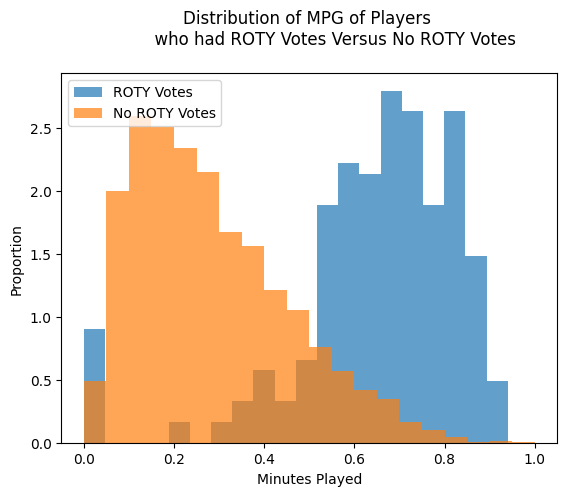

The cutoff is 0.065 minutes per game


In [70]:
royShares = stats_final[stats_final["Share"] > 0]
nonRoyShares = stats_final[stats_final["Share"] == 0]

plt.hist(royShares["MPG"], bins = 20, alpha = 0.7, density=True, label = "ROTY Votes")
plt.hist(nonRoyShares["MPG"], bins = 20, alpha = 0.7, density=True, label = "No ROTY Votes")
plt.ylabel("Proportion")
plt.xlabel("Minutes Played")
plt.title("""Distribution of MPG of Players 
          who had ROTY Votes Versus No ROTY Votes
          """)
plt.legend()
plt.show()

mp_cutoff = royShares["MPG"].mean() - 3*royShares["MPG"].std()
print(f"The cutoff is {mp_cutoff:.3f} minutes per game")

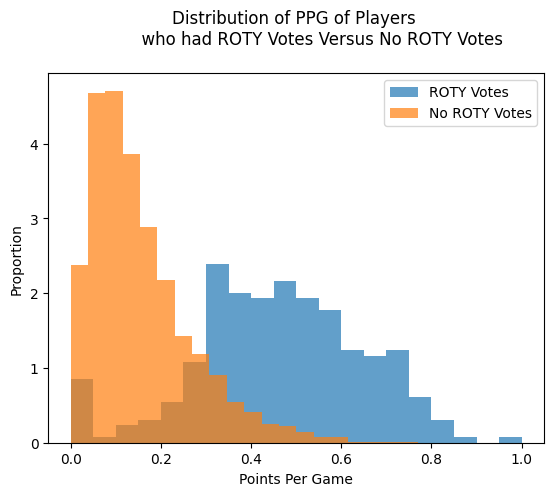

The cutoff is 0.083 points in a game


In [71]:
plt.hist(royShares["PPG"], bins = 20, alpha = 0.7, density=True, label = "ROTY Votes")
plt.hist(nonRoyShares["PPG"], bins = 20, alpha = 0.7, density=True, label = "No ROTY Votes")
plt.xlabel("Points Per Game")
plt.ylabel("Proportion")
plt.title("""Distribution of PPG of Players 
          who had ROTY Votes Versus No ROTY Votes
          """)
plt.legend()
plt.show()

pts_cutoff = royShares["PPG"].mean() - 2 * royShares["PPG"].std()
print(f"The cutoff is {pts_cutoff:.3f} points in a game")

In [72]:
stats_final = stats_final[(stats_final["PPG"] > pts_cutoff) & (stats_final["MPG"] > mp_cutoff)].reset_index(drop = True)
stats_final

,Player,Debut,Age,G,MP,FG,FGA,3P,3PA,FT,...,Tm_SAC,Tm_SAS,Tm_SDC,Tm_SEA,Tm_TOR,Tm_UTA,Tm_VAN,Tm_WAS,Tm_WSB,ROTY
0,James Bailey,"Oct 14, '79, SEA @ SDC",22.0,67.0,0.223453,0.145759,0.166769,0.000000,0.000000,0.107937,...,0,0,0,1,0,0,0,0,0,False
1,Vinnie Johnson,"Oct 16, '79, SEA @ PHO",23.0,38.0,0.100031,0.053763,0.070769,0.000000,0.001818,0.049206,...,0,0,0,1,0,0,0,0,0,False
2,Billy Ray Bates,"Feb 23, '80, POR @ DET",23.0,16.0,0.072330,0.086022,0.089846,0.038835,0.034545,0.044444,...,0,0,0,0,0,0,0,0,0,False
3,Abdul Jeelani,"Oct 12, '79, POR vs. UTA",25.0,77.0,0.395814,0.344086,0.347692,0.000000,0.010909,0.255556,...,0,0,0,0,0,0,0,0,0,False
4,Jim Paxson,"Oct 12, '79, POR vs. UTA",22.0,72.0,0.390890,0.225806,0.283077,0.004854,0.040000,0.101587,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,Zaccharie Risacher,"Oct 23, '24, ATL vs. BRK",19.0,41.0,0.299169,0.201912,0.251692,0.252427,0.312727,0.096825,...,0,0,0,0,0,0,0,0,0,False
2437,Keaton Wallace,"Oct 27, '24, ATL @ OKC",25.0,20.0,0.110496,0.056153,0.067692,0.101942,0.107273,0.014286,...,0,0,0,0,0,0,0,0,0,False
2438,Tidjane Salaün,"Oct 26, '24, CHO vs. MIA",19.0,34.0,0.192367,0.064516,0.104615,0.145631,0.194545,0.033333,...,0,0,0,0,0,0,0,0,0,False
2439,KJ Simpson,"Nov 4, '24, CHO @ MIN",22.0,14.0,0.067098,0.025090,0.048000,0.029126,0.065455,0.026984,...,0,0,0,0,0,0,0,0,0,False


In [73]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Now that all the preprocessing is done, I can now split the dataset into a training, testing, and validation set. The validation set will be one season prior to the current season.

In [74]:
train = stats_final[stats_final["Year"] < 2024]
test = stats_final[stats_final["Year"] == 2024]

In [75]:
X = train[features]
y = train["Share"]

X_test = test[features]

# Baseline XGBoost Regressor Model

I chose the XGBoost Regressor model as XGBoost in general is an industry leading model. This is a linear regression problem, so I will build on this baseline model moving forward.

In [76]:
xgb_r = XGBRegressor(objective ='reg:squaredlogerror',
                  n_estimators = 10, seed = 123,
                  eval_metric=mean_absolute_error)
xgb_r.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x0000022AA59C2DE0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', ...)

In [77]:
preds = xgb_r.predict(X_test)
preds = pd.DataFrame(preds, columns=["Prediction"], index=test.index)
comparison = pd.concat([test[["Player", "Team", "ROTY"]], preds], axis=1)
comparison = comparison.sort_values("ROTY", ascending=False)
comparison.head(1)

,Player,Team,ROTY,Prediction
2371,Victor Wembanyama,San Antonio Spurs,True,0.359213


In [78]:
xgb_predictions = xgb_r.predict(X_test)
xgb_predictions = pd.DataFrame(xgb_predictions, columns=["Predictions"], index=test.index)
comparison_xgb = pd.concat([test[["Player", "ROTY", "Year"]], xgb_predictions], axis=1)
comparison_xgb = comparison_xgb.sort_values("ROTY", ascending=False)
comparison_xgb["Rank"] = list(range(1, comparison_xgb.shape[0]+1))
comparison_xgb = comparison_xgb.sort_values("Predictions", ascending=False)
comparison_xgb["Predicted Decision"] = list(range(1, comparison_xgb.shape[0]+1))
comparison_xgb.head(10)

,Player,ROTY,Year,Predictions,Rank,Predicted Decision
2379,Chet Holmgren,False,2024,0.464168,14,1
2371,Victor Wembanyama,True,2024,0.359213,1,2
2391,Jaime Jaquez Jr.,False,2024,0.132111,26,3
2346,Brandon Miller,False,2024,0.104487,46,4
2381,Cason Wallace,False,2024,0.031818,16,5
2383,Keyonte George,False,2024,0.028529,18,6
2393,Amen Thompson,False,2024,0.014501,28,7
2340,Scoot Henderson,False,2024,0.013514,40,8
2377,Dereck Lively II,False,2024,0.011653,12,9
2388,Trayce Jackson-Davis,False,2024,0.011653,23,10


# Hyperparameter Tuning

Tuning the XGBRegressor model to predict shares.

In [79]:
rX = train[features]
rY = train["Share"]

rX_test = test[features]

In [80]:
xgr = XGBRegressor(boosting_type='dart', objective='reg:squaredlogerror', device='gpu', importance_type='gain',eval_metric=mean_absolute_error)

n_estimators = [50, 100, 150]
learning_rates = [0.05, 0.01, 0.1, 0.2]
max_depths = [4, 7, 10]

grid = dict(learning_rate=learning_rates,n_estimators=n_estimators, max_depth=max_depths)

In [81]:
xgr_tuned = GridSearchCV(estimator=xgr, param_grid=grid, scoring='accuracy', cv=5)
xgr_tuned.fit(rX, rY)

c:\Users\Elijah\miniconda3\envs\machine_learning\Lib\site-packages\xgboost\core.py:160: UserWarning:

[11:01:18] WARNING: D:\bld\xgboost-split_1705650090842\work\src\learner.cc:742: 
Parameters: { "boosting_type" } are not used.


c:\Users\Elijah\miniconda3\envs\machine_learning\Lib\site-packages\xgboost\core.py:160: UserWarning:

[11:01:18] WARNING: D:\bld\xgboost-split_1705650090842\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


c:\Users\Elijah\miniconda3\envs\machine_learning\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning:

Scoring failed. The score on this train-test partition for these 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    boosting_type='dart', callbacks=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='gpu',
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric=<function mean_absolute_error at 0x0000022AA59C2DE0>,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.05, 0.01, 0.1, 0.2],
                         'max_depth': [4, 7, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [82]:
print("Best score: ", xgr_tuned.best_score_)
print("Best estimators: ", xgr_tuned.best_estimator_)
print("Best parameters: ", xgr_tuned.best_params_)

Best score:  nan
Best estimators:  XGBRegressor(base_score=None, booster=None, boosting_type='dart',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x0000022AA59C2DE0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
Best parameters:  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 50}


In [83]:
best_params = xgr_tuned.best_params_

reg = XGBRegressor(**best_params)
reg.fit(X, y)
preds = reg.predict(rX_test)

preds = pd.DataFrame(preds, columns=["Predictions"], index=test.index)
comparison_xgbt = pd.concat([test[["Player", "ROTY", "Year", "Share"]], preds], axis=1)
comparison_xgbt = comparison_xgbt.sort_values("ROTY", ascending=False)
comparison_xgbt["Rank"] = list(range(1, comparison_xgbt.shape[0]+1))
comparison_xgbt = comparison_xgbt.sort_values("Predictions", ascending=False)
comparison_xgbt["Predicted Decision"] = list(range(1, comparison_xgbt.shape[0]+1))
comparison_xgbt.head(10)

,Player,ROTY,Year,Share,Predictions,Rank,Predicted Decision
2371,Victor Wembanyama,True,2024,1.000,0.493779,1,1
2379,Chet Holmgren,False,2024,0.596,0.475121,14,2
2383,Keyonte George,False,2024,0.000,0.175117,18,3
2346,Brandon Miller,False,2024,0.174,0.165267,46,4
2391,Jaime Jaquez Jr.,False,2024,0.020,0.092259,26,5
2340,Scoot Henderson,False,2024,0.000,0.064543,40,6
2389,Brandin Podziemski,False,2024,0.008,0.054843,24,7
2381,Cason Wallace,False,2024,0.000,0.010343,16,8
2339,Toumani Camara,False,2024,0.000,0.009560,39,9
2369,Ausar Thompson,False,2024,0.000,0.009560,5,10


In [84]:
gain_importance = reg.feature_importances_
feature_names = X_test.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
importance_df = importance_df.sort_values(by='Gain', ascending=True)
importance_df.head(10)

,Feature,Gain
36,Tm_BRK,0.0
37,Tm_CHA,0.0
38,Tm_CHH,0.0
39,Tm_CHI,0.0
41,Tm_CLE,0.0
44,Tm_DET,0.0
45,Tm_GSW,0.0
46,Tm_HOU,0.0
47,Tm_IND,0.0
48,Tm_KCK,0.0


In [85]:
fig = px.bar(importance_df, x="Gain", y="Feature", orientation='h',title="XGB Regressor Feature Importance (Gain)", template='simple_white')
fig.update_traces(width=0.5)
fig.update_layout(width=1000,height=1000)
fig.show()

This is a plot of feature importance to give some insight as to what the xgboost 

# Predicting the ROTY for the 2024-2025 Season

We are now ready to predict on the 2024-2025 season! This is all data pulled from 1/31/2025 and will be updated as voting draws closer. 

In [86]:
train2025 = stats_final[stats_final["Year"] < 2025]

test_2025 = stats_final[stats_final["Year"] == 2025]
del test_2025["ROTY"]

In [87]:
newX = train2025[features]
newY = train2025["Share"]

newX_test = test_2025[features]

In [88]:
reg = XGBRegressor(**best_params)
reg.fit(newX, newY)
preds = reg.predict(newX_test)

preds = pd.DataFrame(preds, columns=["Predictions"], index=test_2025.index)
comparison_xgb_final = pd.concat([test_2025[["Player", "Team"]], preds], axis=1)
comparison_xgb_final = comparison_xgb_final.sort_values("Predictions", ascending=False)
comparison_xgb_final["Predicted Decision"] = list(range(1, comparison_xgb_final.shape[0]+1))
comparison_xgb_final.head(10)

,Player,Team,Predictions,Predicted Decision
2416,Stephon Castle,San Antonio Spurs,0.361481,1
2427,Jaylen Wells,Memphis Grizzlies,0.122258,2
2432,Yves Missi,New Orleans Pelicans,0.067735,3
2429,Dalton Knecht,Los Angeles Lakers,0.049600,4
2436,Zaccharie Risacher,Atlanta Hawks,0.048507,5
2411,Carlton Carrington,Washington Wizards,0.038152,6
2424,Tristan Da Silva,Orlando Magic,0.033510,7
2420,Isaiah Collier,Utah Jazz,0.026893,8
2405,Jared McCain,Philadelphia 76ers,0.017475,9
2413,Alex Sarr,Washington Wizards,0.012980,10


# Conclusion

The model has predicted that Stephon Castle will have the most shares for the 2024-2025 Rookie of the Year award. Stephon Castle is averaging 11.9PPG, 2.6RPG, 3.5APG, and shooting 40.4% from the field. In his last 10 games, Castle has been averaging 15.1PPG, 2.6RPG, 3.3APG, and a 44.3 FG%.